# ECON 326: Introduction to Regression using R

* **Authors**: COMET Team (Emrul Hasan, Jonah Heyl, Shiming Wu)
* **Last Update**: 15 August 2022
---

## Outline

### Prerequisites

* Basic R and Jupyter skills
* A theoretical understanding of simple linear relationship
* An understanding of hypothesis testing
* Types of variables (qualitative, quantitative)

### Outcomes

By the end of this notebook, you will be able to:
* Learn how to run a simple linear regression using R
* Create and understand regression outputs in R
* Understand how to interpret coefficient estimates from simple linear regressions in terms of an econometric model
* Examine the various elements of regression objects in R (including fitted values, residuals and coefficients)
* Understand the relationship between $t$-tests and the estimates from simple linear regressions
* Undertand the role of qualitative variables in regression analysis, with a particular emphasis on dummies
* Explain how adding variables to a model changes the results

Note that the data in this exercise is provided under the Statistics Canada Open License:
> <span id="fn1">[<sup>1</sup>](#fn1s)Statistics Canada, Survey of Financial Security, 2019, 2021. Reproduced and distributed on an "as is" basis with the permission of Statistics Canada.Adapted from Statistics Canada, Survey of Financial Security, 2019, 2021. This does not constitute an endorsement by Statistics Canada of this product.</span>


In [1]:
library(tidyverse)
library(haven)
library(dplyr)
source("test2.r")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Warning message:
“package ‘readr’ was built under R version 4.1.2”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘haven’ was built under R version 4.1.3”
Warning message:
“package ‘testthat’ was built under R version 4.1.3”

Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from 

In [2]:
SFS_data <- read_dta("../datasets/SFS_2019_Eng.dta")  #this code is discussed in module 1

SFS_data <- filter(SFS_data, !is.na(SFS_data$pefmtinc))
SFS_data <- rename(SFS_data, income_before_tax = pefmtinc)
SFS_data <- rename(SFS_data, income_after_tax = pefatinc)
SFS_data <- rename(SFS_data, wealth = pwnetwpg)
SFS_data <- rename(SFS_data, gender = pgdrmie)
SFS_data <- rename(SFS_data, education = peducmie)

SFS_data <- SFS_data[!(SFS_data$education=="9"),]
SFS_data$education <- as.numeric(SFS_data$education)
SFS_data <- SFS_data[order(SFS_data$education),]
SFS_data$education <- as.character(SFS_data$education)
SFS_data$education[SFS_data$education == "1"] <- "Less than high school"
SFS_data$education[SFS_data$education == "2"] <- "High school"
SFS_data$education[SFS_data$education == "3"] <- "Non-university post-secondary"
SFS_data$education[SFS_data$education == "4"] <- "University"

SFS_data$gender <- as_factor(SFS_data$gender)
SFS_data$education <- as_factor(SFS_data$education)

In [3]:
# If you want to know more about the variables, you can input the name in dictionary().
# Sometimes you may need to compile 'source("test2.r")' twice. This just creates a dictionary of our variables
dictionary('pefatinc')

[1] "after-tax-income"

## Part 1: Learning About Regressions

What is a regression?  What is the relationship of a regression to other statistical concepts?  How do we use regressions to answer economic questions?

In this notebook, we will explore these questions using our SFS data from Module 1 and learn more about the gender wealth gap. If you remember from last module, we were interested in the wealth gap between male and female lead households.  

We'll begin our analysis by exploring the relationship between wealth and income. Let's start off with a visualization:

Saving 6.67 x 6.67 in image



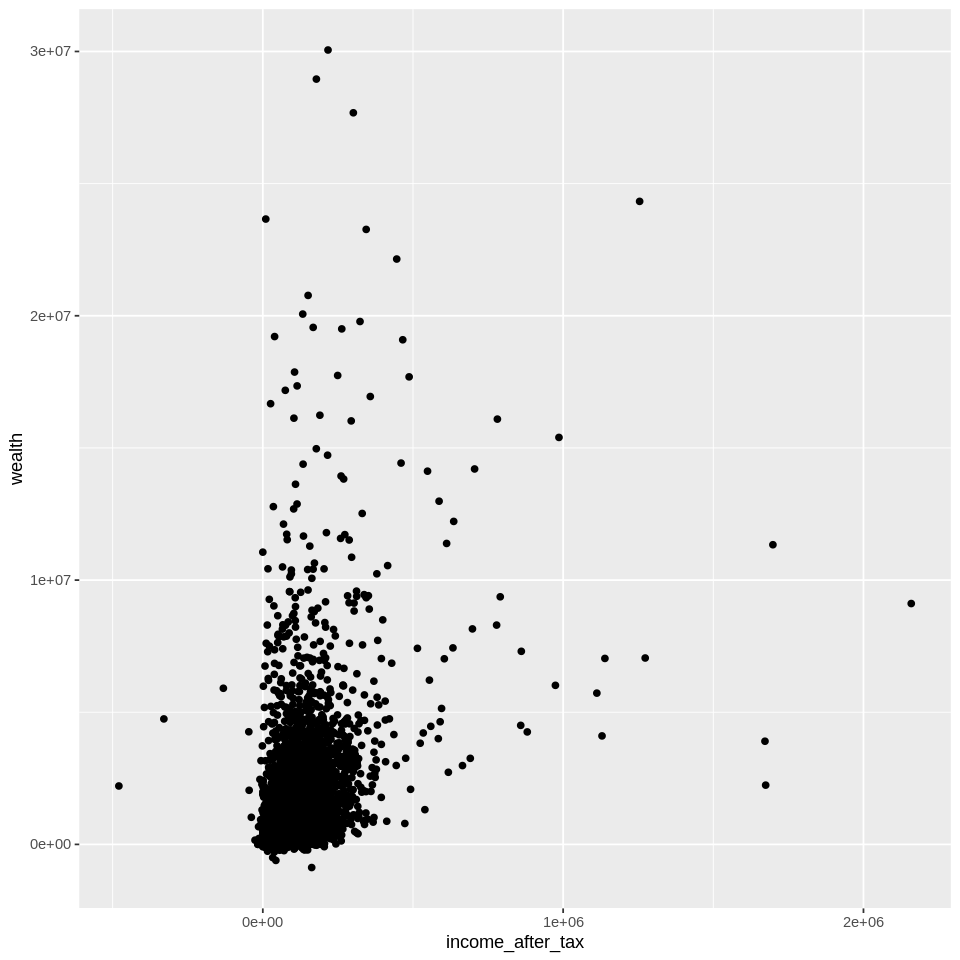

In [5]:
options(repr.plot.width=8,repr.plot.height=8) #controls the image size
f <- ggplot(data = SFS_data,xlim=c(0,2.4*10^6),ylim=c(0,3.4*10^7), aes(x = income_after_tax, y = wealth )) + #defines and labels our x and y.
xlab("income_after_tax") + 
ylab("wealth")+scale_x_continuous()

f + geom_point()



> _Think Deeper_: What do you see here?  Is there anything about this relationship that sticks out to you?  Why does it have the shape it does?

You can probably tell that there is definitely some relationship between wages and after-tax income - but it can be difficult to visualize using a scatterplot alone.  There are far too many points to make out a discernable pattern or relationship here.  

### Regression Models

This is where a **regression model** comes in.  A regression model specifies the relationship between two variables.  For example, a linear relationship would be:

$$ W_i = \beta_0 + \beta_1I_i$$

Where $W_i$ is wealth of family $i$, and $I_i$ is their after-tax income.  In econometrics, we typically refer to $W_i$ as the **outcome** variable, and $I_i$ as the **explanatory** variable; you may have also heard the terms *dependent* and *independent* variables respectively, but these aren't actually very good descriptions of what these variables are in econometrics which is why we won't use them here.  

A model like this is our description of what this relationship is - but it depends on two unknowns: $\beta_0$, $\beta_1$. 

* $\beta_0$ and $\beta_1$ are **parameters** of the model: they are numbers that determine the relationship (intercept and slope, respectively) between $W_i$ and $I_i$ 
* This is a _linear_ relationship because the model we have specified uses coefficients that are characteristic of linear model formulas - note that there are many other kinds of models beyond the linear type seen here.

It is unlikely, if not impossible, for the relationship we observe here to completely explain everything about our data.  We also need to include a term which captures everything that is _not_ described by the relationship we described in the model.  This is called the *residual* term (meaning "leftover").

* The $\epsilon_i$ is the **residual**: it is a component that corresponds to the part of the data which is _not_ described by the model
* Residual terms will usually have certain assumed properties that allow us to estimate the model

Conceptually, you can think about a regression as two parts: the part of the relationship explained by your model ($W_i = \beta_0 + \beta_1 I_i$) and the part which is not explained ($\epsilon_i$).  The process of "fitting" or estimating a regression model refers to finding values for $\beta_0$ and $\beta_1$ such that as little as possible of the model is explained by the residual term.  We write the complete regression equation by combining the two parts of the model:

$$W_i = \beta_0 + \beta_1 I_i + \epsilon_i$$

The goal of regression analysis is to:

1. Estimate this equation (and especially the model parameters) as accurately as possible.
2. Learn about the relationship between $W_i$ and $I_i$ from the results of that estimation

There are many ways to define "as accurately as possible" and similarly there are many ways to "estimate" the equation.  In this course, we use *ordinary least squares* (OLS) as our estimation method which can be understood as the following:

$$(\hat{\beta_0},\hat{\beta_1}) = \arg \min_{b_0,b_1} \sum_{i=1}^{n} (M_i - b_0 - b_1 W_i)^2 =\arg \min_{b_0,b_1} \sum_{i=1}^{n} (e_i)^2$$

It is just the calculus way of writing "choose $\beta_0$ and $\beta_1$ (call them $\hat{\beta_0},\hat{\beta_1}$) such that they minimize the sum of the squared residuals". Ultimately, the goal of doing a regression is to explain as much as possible using the parameters ($\beta_0, \beta_1$) and as little as possible using $\epsilon_i$. Through this equation, we have transformed our statistical problem into a calculus problem, one that can can be solved, for example, by taking derivatives.

There are many, many ways to solve this estimation problem - most of which are built into R. Before getting into how we can estimate using R commands, we'll discuss on how we can estimate manually.

### Example: Manual Estimation

If we think about the residuals as a gauge of error in our model (remember we want to think about the error in absolute terms, we can look at the scatterplot and guess how the model might perform based on how small or large the residuals are from the regression line. As you can probably imagine, this is not the most efficient nor the most accurate way to solve our estimate problem! 

Try to get the best fit you can by playing around with the following example.


[1] "Your SSE is now, 24365382413 , How low can you go?"


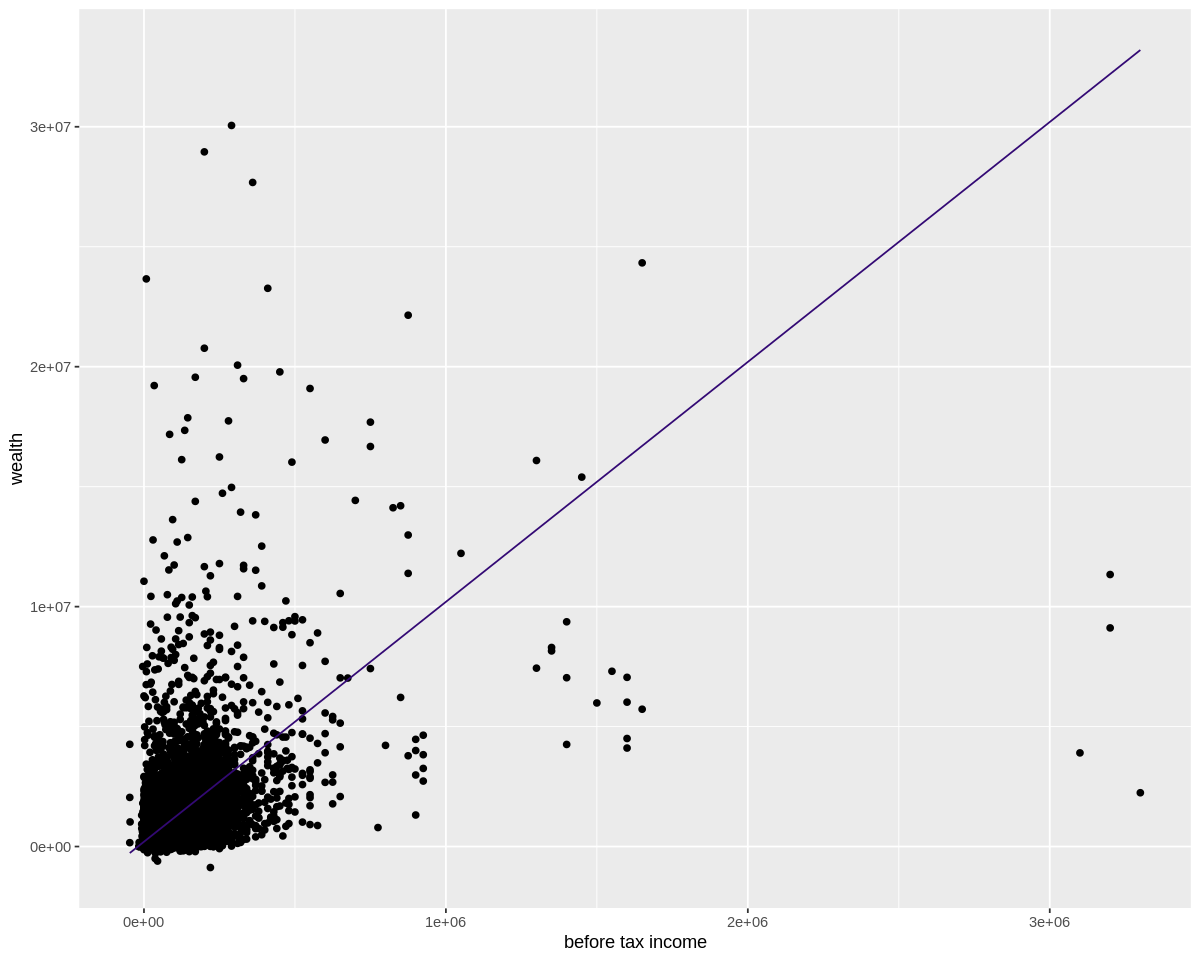

In [49]:
#set the value of B_0 and B_1 with these values

B_0 = 200000  #change me
B_1 =10  #change me

# don't touch the rest of this code - but see if you can understand it!
SSE = sum((SFS_data$wealth - B_0 - B_1*SFS_data$income_after_tax)^2) #sum of our squared errors

SSE_rounded=round(SSE/1000000,0) 
print(paste("Your SSE is now,", SSE_rounded,", How low can you go?")) #prints our SSE value

options(repr.plot.width=10,repr.plot.height=8) #controls the image size

fitted_line = data.frame(income_before_tax = SFS_data$income_before_tax, wealth = B_0 + B_1*SFS_data$income_before_tax) #makes the regression line

f <- ggplot(data = SFS_data, aes(x = income_before_tax, y = wealth),xlim=c(0,3*10^6),ylim=c(0,3*10^7)) + xlab("before tax income") + ylab("wealth")+scale_x_continuous() 
f <- f + geom_point() + geom_line(color = "#330974", data = fitted_line) #style preferences

f #prints our graph with the line

As we change our $\beta_0, \beta_1$, notice how the best fit line changes as well. The closer we fit our line to the data the lower SSE we have

### Simple Regressions in R

Now, let's see how we could use a regression in R to do this.  Regression models look like: `Y ~ X` (the `~` symbol is called "tilde" FYI).

> For now you can ignore the residual terms and parameters when writing the model in R - just focus on the variables.

So, for example, our regression model is 

$$W_i = \beta_0 + \beta_1 I_i + \epsilon_i$$

Which can be written in R as

`wealth ~ income_before_tax`

Regressions are estimated in R using the `lm` command, which contains an argument to specify the dataset. This creates a **linear model object**, which can be used to calculate things (through prediction) or perform tests. It also stores all of the information about the model, such as the coefficient and fit. The model generated using the lm() command can also be printed and summarized to give important basic information about a regression.

Below are a few of the most important elements of a linear model. Let's say, for example, that we called the model ``my_model.``

* ``my_model$coefficients``: gives us the parameter coefficients
* ``my_model$residuals``: gives us the residuals
* ``my_model$fitted.values``: gives us the predicted values

Enough talk! Let's see our model in action here.


In [51]:
regression1 = lm(wealth ~ income_after_tax, data = SFS_data) # take note this is very important!

summary(regression1)
 
head(regression1$coefficients)


Call:
lm(formula = wealth ~ income_after_tax, data = SFS_data)

Residuals:
      Min        1Q    Median        3Q       Max 
-14611481   -625666   -313522    180252  27722234 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      1.698e+05  2.253e+04   7.536 5.25e-14 ***
income_after_tax 9.964e+00  1.897e-01  52.530  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1550000 on 10139 degrees of freedom
Multiple R-squared:  0.2139,	Adjusted R-squared:  0.2139 
F-statistic:  2759 on 1 and 10139 DF,  p-value: < 2.2e-16


(Intercept) income_after_tax 
    1.698262e+05     9.964023e+00

Take a close look at the results.  Identify the following elements:

* The values of the parameters
* The standard errors of the parameters
* The %-of the data explained by the model

> **Test Your Knowledge**: What  %-of the variance in wealth is explained by the model?  
Write the percentage in _decimal form_ and include all decimals given by the model (example, x.xxx - where x are numbers)

In [53]:
answer1 <- 0.2139   #answer goes here
answer1=round(answer1,2)
test_1()

Test passed 🥇
[1] "Success!"


The underlying model and the parameters tells us about the relationship between the different values:

$$W_i = 169826.16 + 9.96 I_i + \epsilon_i$$

Notice, for example:

$$\frac{\partial W_i}{\partial I_i} = \beta_1 = 9.96$$

In other words, when incomes goes up by 1 dollar, we would expect that the wealth accumulated for this given family will rise by 9.96 dollars. This kind of analysis is key to interpreting what this model is telling us.

Finally, let's visualize our fitted model on the scatterplot from before.  How does it compare to your original model?

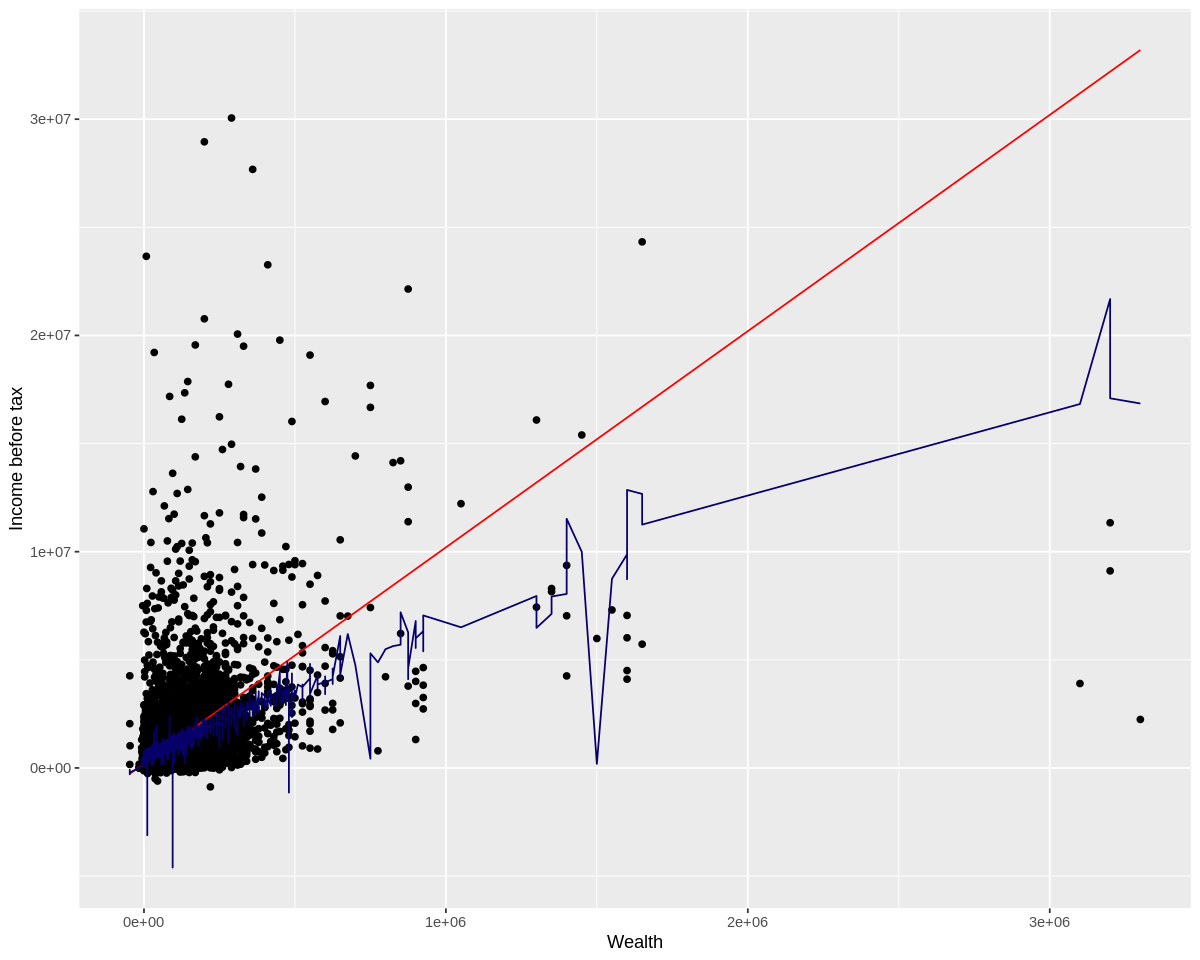

In [55]:
options(repr.plot.width=10,repr.plot.height=8) #style preferences

fitted_line2 = data.frame( income_before_tax = SFS_data$income_before_tax, wealth = regression1$fitted.values)#this is our blue fitted line

f <- ggplot(data = SFS_data, aes(x = income_before_tax, y = wealth)) + xlab("Wealth") + ylab("Income before tax")+scale_x_continuous() #defines our x and y
f <- f + geom_point() + geom_line(color = "#ff0000", data = fitted_line) + geom_line(color = "#070069", data = fitted_line2) #style preferences

f #prints  graph

As you can see - there's a very close relationship between `after_tax_income` and `wealth`. The red line is a regression line of wealth and after_tax_income, whereas the blue line is the fitted values.

Notice as well we have negative values? Negative income and negative wealth is weird. We will deal with this later. 

## Part 2: Simple Regressions and $t$-Tests

What if we wanted to work with a qualitative variable like `gender`?

Regression models can still incorporate this kind of variable - which is good, because (as the Census makes clear) this is the most common type of variable in real-world data.  How is this possible?  

Let's start out with the simplest kind of qualitative variable: a **dummy** (0 or 1) variable. Let's use Male = $0$ and Female = $1$. Consider the regression equation:

$$W_i = \beta_0 + \beta_1 G_i + \epsilon_i ~, \text{where}\ G_i \ \text{is Gender}$$

Consider the conditional expectation:

$$E[W_i|G_i = \text{Male}] = \beta_0 + \beta_1 \cdot 1 + \epsilon_i$$

$$E[W_i|G_i = \text{Female}] = \beta_0 + \beta_1 \cdot 0 + \epsilon_i$$

By the OLS reggression assumptions, we have that $E[\epsilon_i|G_i] = 0 $, so: 

$$E[W_i|G_i = \text{Female}] = \beta_0 + \beta_1$$

$$E[W_i|G_i = \text{Male}] = \beta_0$$

Combining these two expressions:

$$\beta_1 = E[W_i|G_i = \text{Female}] - E[W_i|G_i = \text{Male}] = \beta_1-\beta_0$$

What this tells us:

1.  We can include **dummy** variables in regressions just like quantitative variables
2.  The coefficients on the dummy variable have meaning in terms of the regression model
3.  The coefficients measure the (average) difference in the dependent variable between the two levels of the dummy variable

We can estimate this relationship of gender and wealth using R. As we investigate the wealth gap between male and female lead households, we might expect to see a negative sign on the coefficient - that is, if we anticipate that female lead households will have less wealth than male lead households.

In [56]:
regression2 <- lm(wealth ~ gender, data = SFS_data)

summary(regression2)


Call:
lm(formula = wealth ~ gender, data = SFS_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2003534  -882034  -510429   239866 28926966 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1128034      22315  50.551  < 2e-16 ***
genderFemale  -235286      35394  -6.648 3.13e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1744000 on 10139 degrees of freedom
Multiple R-squared:  0.00434,	Adjusted R-squared:  0.004241 
F-statistic: 44.19 on 1 and 10139 DF,  p-value: 3.131e-11


What do you see here?

> **Test Your Knowledge**:  What is the difference in average wealth between male and female lead households?

In [58]:
# input the answer (to 1 decimal place, don't forget to add a negative sign, if relevant)
answer2 <- -235286       # your answer here
answer2=round(answer2,2)
test_2()

Test passed 🥇
[1] "Success!"


The number  might seem familiar if you remember what we learned about a $t$-test from earlier.  Remember this result?

In [61]:
t1 = t.test(
       x = filter(SFS_data, gender == "Male")$wealth,
       y = filter(SFS_data, gender == "Female")$wealth,
       alternative = "two.sided",
       mu = 0,
       conf.level = 0.95)

t1 

t1$estimate[1] - t1$estimate[2]


	Welch Two Sample t-test

data:  filter(SFS_data, gender == "Male")$wealth and filter(SFS_data, gender == "Female")$wealth
t = 6.9324, df = 9710.4, p-value = 4.401e-12
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 168756.2 301815.0
sample estimates:
mean of x mean of y 
1128033.5  892747.9 


mean of x 
 235285.6

Look closely at this result, and the result above.  What do you see?  What is the relationship here?

This is a very important result because a dummy variable regression is an example a two sample comparison.  Why is this?  Recall:

$$\beta_1 = E[W_i|G_i = \text{Female}] - E[W_i|G_i = \text{Male}]$$

The regression coefficient of $\beta_1$ can be interpreted as a comparison of two means.  This is exactly the same as what the $t$-test is doing. Comparing two means by different groups - groups which are specified by $G_i = \text{Male}$  or $G_i = \text{Female}$.

In other words, another way of thinking about a regression is as a `super` comparison of means test. However, regressions can handle analysis using qualitative (dummy) variables as a well as quantitative variables, which regular comparison of means tests cannot handle.

### Multiple Levels

Okay, but what if you have a qualitative variable that takes on _more_ than two levels?  For example, the `education` variable includes four different education classes.

In [63]:
SFS_data %>%
group_by(education) %>%
summarize(number_of_observations = n())

education,number_of_observations
<fct>,<int>
Less than high school,1216
High school,2279
Non-university post-secondary,2819
University,3827


In this case, the idea is that you can replace a qualitative variable by a *set of dummies*. Consider the following set of variables:

* `d_1`: Is highest education less than high school? (Yes/No)
* `d_2`: Is highest education high school? (Yes/No)
* `d_3`: Is highest education non-university post-secondary? (Yes/No)
* `d_4`: Is highest education university? (Yes/No)

These four dummy variables capture the same information as the qualitative variable `education`. In other words, if we were told the value of `education` we could discern which of these dummies were `Yes` or `No`, and vice-versa.  In fact, if wetake a closer look, we'll notice that we actually only need three of the four to figure our the value of `education`.  For example, if I told you that `d_4`, `d_3`, `d_2` were all "No", what would the value of `education` be?

In other words, one of the dummies is redundant in helping us understand the qualitative variable. This property is important; we usually will omit one possible dummy to include only the minimum number of variables needed to explain the qualitative variable in question. This omitted dummy is called the **base level**. If we forget about this and still add 4 dummy variables, we would be committing a dummy variable trap.  

* Which one should be the base level?  It doesn't matter, from a technical perspective. 

> **Test Your Knowledge**: suppose you have a qualitative variable with $k$ distinct levels. What is the minimum number of *possible* ways to represent a set of dummies if you don't want to include any redundant variables?

* **A**: $k$
* **B**: $k-1$
* **C**: $k+1$
* **D**: $k^2$

In [73]:
 source("test2.r")

answer2.5 <- "b" # type in your answer here 
answer2.5_caps=  toupper(answer2.5)
print(answer2.5_caps)
test_2.5()

[1] "B"
Test passed 😀
[1] "Success!"


In general, in R, most commands will automatically handle this process of creating dummies from qualitative variables. As you saw with the simple regression, R created them for you. You can also create dummies using a variety of commands, if necessary - but in general, if you tell R that your variables are factors, it will automatically handle the creation of dummies properly.

Technically, the example above which includes multiple variables is called a **multiple regression** model, which we haven't covered yet.

Let's explore regression some more, in the following series of exercises.

## Part 3: Exercises

### Activity 1
Last week, we briefly explored the idea of the wealth gap and explored the idea that it could be caused by some income related factors. We can now examine this issue directly using regressions. Run a regression with * before tax income * on male and female lead households.

<em>Tested objects:</em> ``regm`` (the regression for males).<em>Tested objects:</em> ``regm`` (the regression for females).

In [78]:
# Quiz 1

# Regression for males
regm <- lm(wealth ~ income_before_tax, filter(SFS_data, gender == "Male")) # Replace "..." with the appropriate variables 
#remember answers are case sensitive!

# Quiz 2
# Regression for females
regf <- lm(wealth ~ income_before_tax, data = filter(SFS_data, gender == "Female")) #remember answers are case sensitive!

summary(regm) # Allow us to view regm's coefficient estimates
summary(regf) # Same as above, but for regf

test_3() # Quiz1
test_4() # Quiz2


Call:
lm(formula = wealth ~ income_before_tax, data = filter(SFS_data, 
    gender == "Male"))

Residuals:
      Min        1Q    Median        3Q       Max 
-16443704   -719054   -431672    223430  27934239 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       5.248e+05  2.745e+04   19.12   <2e-16 ***
income_before_tax 5.503e+00  1.523e-01   36.12   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1702000 on 6108 degrees of freedom
Multiple R-squared:  0.176,	Adjusted R-squared:  0.1759 
F-statistic:  1305 on 1 and 6108 DF,  p-value: < 2.2e-16



Call:
lm(formula = wealth ~ income_before_tax, data = filter(SFS_data, 
    gender == "Female"))

Residuals:
     Min       1Q   Median       3Q      Max 
-5704141  -518359  -181780   212014 17772334 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       1.815e+05  2.606e+04   6.964 3.85e-12 ***
income_before_tax 9.450e+00  2.226e-01  42.446  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1267000 on 4029 degrees of freedom
Multiple R-squared:  0.309,	Adjusted R-squared:  0.3088 
F-statistic:  1802 on 1 and 4029 DF,  p-value: < 2.2e-16


Test passed 🎊
[1] "Success!"
Test passed 🥳
[1] "Success!"


#### Short Answer 1
**Prompt:** How do we interpret the coefficient estimate on ``income`` in each of these regressions?

<font style="color:red">Answer in red here!</font>


### Activity 2

We might think that income inequality between females and males might depend on the educational gaps between these two groups. In this activity, we will explore how the income gap varies by education. First, let's see the factor levels of the `education`:

In [80]:
levels(SFS_data$education) # Run this

[1] "Less than high school"         "High school"                  
[3] "Non-university post-secondary" "University"

As we can see, there are a few education groups in this dataframe. Let's estimate the income gap (with no controls) for each of the four groups separately:

* Less than high school
* High school
* Non-university post-secondary
* University

<em>Tested objects:</em> ``rege2`` (High School), ``rege4`` (University)

Notice we don't need to do 4 regressions we could just do three.



In [107]:
 source("test2.r")

#rege1 is a reggression performed on people, with a less than high scchool education
rege1 <- lm(income_before_tax ~gender, data = filter(SFS_data, education == "Less than high school")) #what should replace the ...
#rege2 is the same as rege1,but we are looking at people with a high school education
rege2 <- lm(income_before_tax ~gender, data = filter(SFS_data, education == "High school")) #fill in the blanks

rege3 <- lm(income_before_tax ~ gender, data = filter(SFS_data, education == "Non-university post-secondary")) #remember answers are case sensitive!

rege4 <- lm(income_before_tax ~gender, data = filter(SFS_data,education == "University"))

# store the summaries (but don't show them!  too many!)
sum20 <- summary(rege1)
sum30 <- summary(rege2)
sum40 <- summary(rege3)
sum50 <- summary(rege4)

test_9() 
test_10() 
test_11() 
test_12() 

Test passed 🌈
[1] "Success!"
Test passed 🥳
[1] "Success!"
Test passed 🥳
[1] "Success!"
Test passed 😀
[1] "Success!"


In [108]:
summary(rege1)


Call:
lm(formula = income_before_tax ~ gender, data = filter(SFS_data, 
    education == "Less than high school"))

Residuals:
    Min      1Q  Median      3Q     Max 
 -54641  -29641  -16227   10359 1276523 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)     47141       2290  20.582  < 2e-16 ***
genderFemale   -23663       3748  -6.313 3.83e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 63230 on 1214 degrees of freedom
Multiple R-squared:  0.03178,	Adjusted R-squared:  0.03099 
F-statistic: 39.85 on 1 and 1214 DF,  p-value: 3.834e-10


The code below will tabulate a brief summary of each regression:

In [109]:
# just run me.  You don't need to edit this

Educ_Group <- c("Less than high school", "High School", "Non-university post-secondary", "University") #defines column 1
Income_Gap <- c(rege1$coefficients[2], rege2$coefficients[2], rege3$coefficients[2], rege4$coefficients[2]) #defines column 2
Std._Error <- c(sum20$coefficients[2,2], sum30$coefficients[2,2], sum40$coefficients[2,2], sum50$coefficients[2,2]) #defines column 3
t_Value <- c(sum20$coefficients[2,3], sum30$coefficients[2,3], sum40$coefficients[2,3], sum50$coefficients[2,3]) #defines column 4
p_Value <- c(sum20$coefficients[2,4], sum30$coefficients[2,4], sum40$coefficients[2,4], sum50$coefficients[2,4]) #defines column 5

tibble(Educ_Group, Income_Gap, Std._Error, t_Value, p_Value) #it's like a table but a tibble

Educ_Group,Income_Gap,Std._Error,t_Value,p_Value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Less than high school,-23663.40,3748.467,-6.312821,3.834282e-10
High School,-29719.23,3181.622,-9.340907,2.198753e-20
Non-university post-secondary,-33611.69,3186.523,-10.548077,1.541777e-25
University,-49282.00,5491.501,-8.974232,4.379491e-19


#### Short Answer 3
**Prompt**: What happens to the income gap as we move across eduction groups? What might explain these changes? (hint: think back to module 1!)

<font style="color:red">Answer in red here!</font>

### Activity 3
As we observed in last week's worksheet, the income gap could differ by education level. Since there are many education categories, however, we may not want to examine this by running a regression for each education level separately. 

Instead, we could run a single regression and add education level as a second regressor, $E_i$: 

$$I_i = \beta_0 + \beta_1 G_i + \beta_2 E_i + \epsilon_i$$

This is actually a **multiple regression**, which we will learn about next week - but from the point of the this lesson, the idea is that it is "run" in R essentially in the same way as a simple regression.  Estimate the regression model above without $E_i$, then re-estimate the model with $E_i$ added. **USE INCOME BEFORE TAX**. 

<em>Tested objects:</em> ``reg2A`` (regression without controls), ``reg2B`` (regression with controls).

In [111]:
# Simple regression (just gender)
reg2A <- lm(income_before_tax~ gender, data = SFS_data) # this one works already

# Regression with controls
reg2B <-  lm(income_before_tax ~ gender + education, data = SFS_data) # replace the ...

summary(reg2A)
summary(reg2B)
#this will look ugly; try to look carefully at the output

test_7()
test_8() 


Call:
lm(formula = income_before_tax ~ gender, data = SFS_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-156614  -65269  -26269   34731 3190386 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    109614       1593   68.80   <2e-16 ***
genderFemale   -34344       2527  -13.59   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 124500 on 10139 degrees of freedom
Multiple R-squared:  0.01789,	Adjusted R-squared:  0.01779 
F-statistic: 184.7 on 1 and 10139 DF,  p-value: < 2.2e-16



Call:
lm(formula = income_before_tax ~ gender + education, data = SFS_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-199854  -52854  -17252   29784 3147146 

Coefficients:
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                               52358       3542  14.784  < 2e-16 ***
genderFemale                             -37638       2425 -15.519  < 2e-16 ***
educationHigh school                      31811       4240   7.503 6.78e-14 ***
educationNon-university post-secondary    48532       4096  11.847  < 2e-16 ***
educationUniversity                      100495       3932  25.556  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 119400 on 10136 degrees of freedom
Multiple R-squared:  0.09774,	Adjusted R-squared:  0.09739 
F-statistic: 274.5 on 4 and 10136 DF,  p-value: < 2.2e-16


Test passed 🥇
[1] "Success!"
Test passed 🥳
[1] "Success!"


#### Short Answer 4

Prompt: Compare the estimated income gap with and without $E_i$ in the regression. What happens to the gap when we add $E_i$?

<font style="color:red">Answer in red here!</font>

### Theoretical Activity 1
When we deal with large quantitative variables, we often take the natural log of it:

In [112]:
W = log(SFS_data$wealth[SFS_data$wealth>0]) 

You may recall that the derivative of the log of a variable is approximately equal to percentage change in the variables:

$$\frac{dln(x)}{dx} \approx \frac{\Delta x}{x}$$ 

Thus, when we find the marginal effect of some continuous regressor $X_i$ (say, `income`):

$$ln(W_i) = \beta_0 + \beta_1 I_i + \epsilon_i \implies \frac{\Delta W_i}{W_i} \approx \beta_1 \Delta I_{i}$$

This allows us to interpret the changes in a continuous variable as associated with a percentage change in wealth; for instance, if we estimate a coefficient of $0.02$ on `income_before_tax`, we say that when a family's income before tax increases by 1 CAD, the corresponding wealth increases by 2 percent on average.

Notice as well we are now talking about percent changes, rather than units.

Let's generate two variables that take the natural log of the wealth <em>and</em> market income from the `SFS_data` dataframe (hint: use a technique that we introduced last week). Then, estimate the effect of logarithmic market income on logarithmic wealth.

<em>Tested Objects:</em> ``lnreg``

In [119]:
#Generate log wage variable
SFS_data <- SFS_data %>%
               mutate(lnincome = log(SFS_data$income_before_tax)) %>% # what goes here?
               mutate(lnwealth = log(SFS_data$wealth)) # what goes here?


Warning message in .fn(vec_data(.x), ...):
“NaNs produced”
Warning message in log(SFS_data$wealth):
“NaNs produced”


Notice warning message "NaNs produced". NaN means "Not a Number". This happens because we had negative income and negative wealth. No matter how low our incomes are, the more we work, wealth and income should increase. 

In [117]:


# fix NANs
SFS_data_logged <- SFS_data %>%
               filter(income_before_tax>0) %>% #removes negative values
               filter(wealth>0)  #removes negative values
    
# Log Regression 
lnreg <- lm(lnwealth ~ lnincome, data = SFS_data_logged) #the new and improved regression


summary(lnreg)

test_5() #Quiz7


Call:
lm(formula = lnwealth ~ lnincome, data = SFS_data_logged)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.6807 -0.7359  0.3098  1.0290  5.7473 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.17242    0.14599   42.28   <2e-16 ***
lnincome     0.61532    0.01316   46.74   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.612 on 9137 degrees of freedom
Multiple R-squared:  0.193,	Adjusted R-squared:  0.1929 
F-statistic:  2185 on 1 and 9137 DF,  p-value: < 2.2e-16


Test passed 🎉
[1] "Success!"


#### Short Answer 5
Prompt: How do we interpret each of these estimates?  (Hint: what does a 1-unit change in the explanatory variable mean here?)


<font style="color:red"> Answer here in red</font>

### Optional: Bonus Activity 4 

You have learned about a linear regression model of income; however, income really follows a Pareto distribution. For now, using a linear approximation to find the wage gap is fine. We may want to know stuff about the underlying distribution of income in male and female lead households, however. Here's the PDF of pareto distribution:

$$f(x) = {\displaystyle {\frac {\alpha x_{\mathrm {m} }^{\alpha }}{x^{\alpha +1}}}} $$

Ok, now with regression remember we said that we estimate the parameter given the data. To do this we said you could use Calcus or methods other than OLS. Here the probability of the data can be approximated by assuming independence between each $x_i$. If we do this, the probability of the data is given by:

$$\Pi_{i=1}^n f(x)$$

Now we can just make a function in r and optimize over it which performs essentially the same operation as a linear regression.



In [1]:
x=filter(SFS_data,gender=='Female')
x <- filter(x, is.numeric(income_before_tax))
x <- x$income_before_tax

#x[,1:4024]

ERROR: Error in as.ts(x): object 'SFS_data' not found


In [2]:
calc <- function (x){
    q=0
for (i in x){
    if (i >0){
      a= log(i[1]) }
        if (is.numeric(a)==TRUE){
            q=q+a }
    }
return (q)
}

In [3]:
calc(x)

ERROR: Error in calc(x): object 'x' not found


In [4]:
ell <- function(a,q,xm,n) { # we use the log function of the pareto distrubtion instead
    d=(n*log(a))
    b=(-1)*(a+1)*q
    c=a*log(xm)*n 
    return (d+b+c)
}

In [ ]:
a = optimize(ell,c(2,50),maximum=TRUE,q=43074.1853103325,xm=40000,n=length(x))
a
a_women=a$maximum 

In [ ]:
y=filter(SFS_data,gender=='Male')
y <- filter(y, is.numeric(income_before_tax))
y <- y$income_before_tax
a_men = optimize(ell,c(2,1000),maximum=TRUE,q=calc(y),xm=65000,n=length(y))
a_men = a_men$maximum
a_men

The theoretical mean of the Pareto distribution is,  

$$ \frac{\alpha x_m}{\alpha -1} $$
Can you calculate the expected income gap with the Pareto distribution assumption.


In [ ]:
xmw=40000
xmm=65000
income_gap =((a_women* xmw )/ (a_women-1)) - ((a_men* xmm )/ (a_men-1))
income_gap #note we set xm oursleves (I did this by playing around with xm, and doing abit of research) see if you can get a better xm.